# Fetch NOAA GEFS Forecasts for Basin Points

This notebook loads basin centroid coordinates from a CSV file and fetches the corresponding NOAA GEFS forecast data for each point.

In [2]:
# Import required libraries
import os
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
import json

# Suppress warnings about chunking
warnings.filterwarnings('ignore', message='The specified chunks')

## Load Basin Centroid Coordinates

In [3]:
# Define paths for input and output data
basin_centroids_path = "../data/basin_centroids_with_grid_points.csv"
output_dir = "../data/basin_forecasts"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load basin centroids with grid points
try:
    basin_points = pd.read_csv(basin_centroids_path)
    print(f"Loaded {len(basin_points)} basin points from {basin_centroids_path}")
    display(basin_points)
except FileNotFoundError:
    print(f"Error: File {basin_centroids_path} not found.")
    print("Run the extract_basin_centroids.ipynb notebook first to generate this file.")
    basin_points = None

Loaded 5 basin points from ../data/basin_centroids_with_grid_points.csv


,basin_name,centroid_lat,centroid_lon,nearest_lat,nearest_lon,grid_distance_km
0,innerste_reservoir_catchment_Basin_0,51.834451,10.307828,51.75,10.25,10.198042
1,oker_reservoir_catchment_Basin_0,51.816468,10.447276,51.75,10.50,8.232830
2,ecker_reservoir_catchment_Basin_0,51.810056,10.584058,51.75,10.50,8.833746
3,soese_reservoir_catchment_Basin_0,51.752310,10.383225,51.75,10.50,8.042719
4,grane_reservoir_catchment_Basin_0,51.884391,10.357203,52.00,10.25,14.807236


## Connect to NOAA GEFS Dataset

In [4]:
# Function to connect to the NOAA GEFS dataset
def connect_to_gefs_dataset(variables=None, email="optional@email.com"):
    """Connect to the NOAA GEFS dataset and return a dataset object.
    
    Args:
        variables (list, optional): List of variable names to load. If None, all variables are loaded.
        email (str, optional): Email address for tracking dataset usage.
        
    Returns:
        xarray.Dataset: The loaded dataset
    """
    zarr_url = f"https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email={email}"
    
    try:
        if variables:
            # Load only the specified variables to reduce memory usage
            ds = xr.open_zarr(zarr_url, decode_timedelta=True, consolidated=True)
            # Select just the requested variables and coordinates
            ds = ds[variables]
        else:
            # Load all variables
            ds = xr.open_zarr(zarr_url, decode_timedelta=True, consolidated=True)
            
        print(f"Connected to NOAA GEFS dataset with dimensions: {dict(ds.dims)}")
        return ds
    except Exception as e:
        print(f"Error connecting to NOAA GEFS dataset: {e}")
        return None

In [5]:
# Connect to the dataset with just the variables we need
# For hydrological modeling, we typically need temperature, precipitation, and sometimes wind/humidity
variables = [
    'temperature_2m',                        # 2m air temperature
    'precipitation_surface',                 # Total precipitation
    'relative_humidity_2m',                  # Relative humidity
    'downward_long_wave_radiation_flux_surface',  # Surface downward long-wave radiation
    'downward_short_wave_radiation_flux_surface', # Surface downward short-wave radiation
    'precipitable_water_atmosphere',         # Precipitable water
    'pressure_surface',                      # Surface pressure
    'maximum_temperature_2m',                # Maximum temperature
    'minimum_temperature_2m',                # Minimum temperature
    'total_cloud_cover_atmosphere',          # Total cloud cover
    'wind_u_10m',                            # 10m U wind component
    'wind_v_10m'                             # 10m V wind component
]

# Get the latest GEFS forecast dataset
ds = connect_to_gefs_dataset(variables,"gregor.johnen@uni-due.de")

# Display basic information about the dataset
if ds is not None:
    print("\nDataset Variables:")
    for var_name in ds.data_vars:
        var = ds[var_name]
        print(f"  - {var_name}: {var.dims} ({var.attrs.get('units', 'no units')})")
        
    # Get information about forecast dates
    init_times = pd.to_datetime(ds.init_time.values)
    latest_init = init_times.max()
    print(f"\nLatest forecast initialization time: {latest_init}")

Connected to NOAA GEFS dataset with dimensions: {'init_time': 1649, 'ensemble_member': 31, 'lead_time': 181, 'latitude': 721, 'longitude': 1440}

Dataset Variables:
  - temperature_2m: ('init_time', 'ensemble_member', 'lead_time', 'latitude', 'longitude') (C)
  - precipitation_surface: ('init_time', 'ensemble_member', 'lead_time', 'latitude', 'longitude') (mm/s)
  - relative_humidity_2m: ('init_time', 'ensemble_member', 'lead_time', 'latitude', 'longitude') (%)
  - downward_long_wave_radiation_flux_surface: ('init_time', 'ensemble_member', 'lead_time', 'latitude', 'longitude') (W/(m^2))
  - downward_short_wave_radiation_flux_surface: ('init_time', 'ensemble_member', 'lead_time', 'latitude', 'longitude') (W/(m^2))
  - precipitable_water_atmosphere: ('init_time', 'ensemble_member', 'lead_time', 'latitude', 'longitude') (kg/(m^2))
  - pressure_surface: ('init_time', 'ensemble_member', 'lead_time', 'latitude', 'longitude') (Pa)
  - maximum_temperature_2m: ('init_time', 'ensemble_member', '

/tmp/ipykernel_383851/1251781220.py:24: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Connected to NOAA GEFS dataset with dimensions: {dict(ds.dims)}")


## Extract Forecast Data for Basin Points

In [6]:
# Function to extract forecast data for a specific point
def extract_point_forecast(ds, lat, lon, basin_name, init_time=None, latest_only=False):
    """Extract forecast data for a specific lat/lon point.
    
    Args:
        ds (xarray.Dataset): The NOAA GEFS dataset
        lat (float): Latitude of the point
        lon (float): Longitude of the point
        basin_name (str): Name of the basin (for labeling)
        init_time (str, optional): Specific initialization time to extract
        latest_only (bool): If True, only extract the most recent forecast
        
    Returns:
        xarray.Dataset: Dataset containing forecast data for the specified point
    """
    try:
        # Select the point using nearest neighbor
        point_ds = ds.sel(latitude=lat, longitude=lon, method="nearest")
        
        # Get the actual coordinates selected (might be slightly different from input)
        actual_lat = float(point_ds.latitude.values)
        actual_lon = float(point_ds.longitude.values)
        print(f"Selected point for {basin_name}: ({actual_lat}, {actual_lon})")
        
        # If init_time is specified, select only that initialization time
        if init_time:
            point_ds = point_ds.sel(init_time=init_time)
            print(f"Selected forecast initialized at: {init_time}")
        # If latest_only, select only the most recent forecast initialization
        elif latest_only:
            latest_init = pd.to_datetime(point_ds.init_time.values).max()
            point_ds = point_ds.sel(init_time=str(latest_init))
            print(f"Selected latest forecast initialized at: {latest_init}")
        # Otherwise, keep all initialization times
        else:
            init_count = len(point_ds.init_time)
            print(f"Keeping all {init_count} initialization times")
        
        # Add basin information as attributes
        point_ds.attrs['basin_name'] = basin_name
        point_ds.attrs['requested_lat'] = lat
        point_ds.attrs['requested_lon'] = lon
        point_ds.attrs['actual_lat'] = actual_lat
        point_ds.attrs['actual_lon'] = actual_lon
        
        return point_ds
    except Exception as e:
        print(f"Error extracting data for {basin_name} at ({lat}, {lon}): {e}")
        return None

In [7]:
# Update the interpolate_to_hourly function to ensure full hourly coverage
def interpolate_to_hourly(ds):
    """Interpolate forecast data to hourly resolution for the full forecast period.
    
    Args:
        ds (xarray.Dataset): Dataset with native forecast resolution (3-hourly for 0-240h, 6-hourly for 243-840h)
        
    Returns:
        xarray.Dataset: Dataset with hourly resolution for the full 35-day forecast
    """
    try:
        print("Interpolating to hourly resolution...")
        
        # Get the current lead_time values
        lead_times = ds.lead_time.values
        
        # Check the maximum lead time - it should be near 840 hours (35 days)
        max_hours = lead_times.max().astype('timedelta64[h]').astype(float)
        print(f"Maximum lead time in original dataset: {max_hours:.1f} hours ({max_hours/24:.1f} days)")
        
        # Ensure we get the full 35-day (840-hour) forecast period
        # If max_hours is significantly less than 840, issue a warning
        if max_hours < 800:  # Allow some flexibility (might not be exactly 840)
            print(f"WARNING: Maximum lead time ({max_hours:.1f} hours) is less than expected for 35-day forecast (840 hours)")
            print("The dataset may be truncated or incomplete.")
        
        # Create an array of hourly lead times from 0 to the maximum lead time
        # Ensure we go all the way to at least 840 hours if data is available
        target_max_hours = max(max_hours, 840)  # Use at least 840 hours, or more if available
        hourly_lead_times = pd.timedelta_range(start='0 days', end=f"{int(target_max_hours)} hours", freq='1H')
        
        # Convert to the same type as the original lead_times to avoid dtype conflicts
        hourly_lead_times = np.array([pd.to_timedelta(t) for t in hourly_lead_times])
        
        # Create a new dataset with hourly resolution
        # Use nearest interpolation for the best behavior with discontinuous data
        hourly_ds = ds.interp(
            lead_time=hourly_lead_times,
            method='nearest',
            kwargs={"fill_value": "extrapolate"}
        )
        
        # Add metadata to note this has been interpolated to hourly
        hourly_ds.attrs['temporal_interpolation'] = 'hourly interpolation from native resolution (3h/6h)'
        hourly_ds.attrs['interpolation_date'] = str(datetime.now())
        hourly_ds.attrs['original_max_lead_time_hours'] = float(max_hours)
        hourly_ds.attrs['interpolated_lead_time_count'] = len(hourly_lead_times)
        
        # Report on the original and new resolution
        print(f"Original lead_time steps: {len(lead_times)}")
        print(f"New hourly lead_time steps: {len(hourly_lead_times)}")
        print(f"Hourly coverage: 0 to {hourly_lead_times[-1].astype('timedelta64[h]').astype(float):.1f} hours")
        
        return hourly_ds
    except Exception as e:
        print(f"Error interpolating to hourly resolution: {e}")
        import traceback
        traceback.print_exc()
        return ds

In [8]:
# Function to process forecasts for all basin points
def process_basin_points(ds, basin_points):
    """Process forecasts for all basin points with all initialization times.
    
    Args:
        ds (xarray.Dataset): The NOAA GEFS dataset
        basin_points (pandas.DataFrame): DataFrame with basin centroid coordinates
        
    Returns:
        dict: Dictionary of datasets for each basin
    """
    if basin_points is None or ds is None:
        print("Error: No basin points or dataset available.")
        return {}
    
    # Dictionary to store processed datasets
    basin_datasets = {}
    
    # Process each basin point
    for idx, row in basin_points.iterrows():
        basin_name = row['basin_name']
        
        # Use the nearest grid point coordinates if available
        if 'nearest_lat' in row and 'nearest_lon' in row and not pd.isna(row['nearest_lat']):
            lat = row['nearest_lat']
            lon = row['nearest_lon']
            print(f"\nUsing nearest grid point for {basin_name}: ({lat}, {lon})")
        else:
            lat = row['centroid_lat']
            lon = row['centroid_lon']
            print(f"\nUsing exact centroid for {basin_name}: ({lat}, {lon})")
        
        # Extract all forecasts for this point
        print(f"Extracting all forecasts for {basin_name}...")
        point_ds = extract_point_forecast(ds, lat, lon, basin_name)
        
        if point_ds is not None:
            print(f"Processed original resolution forecasts for {basin_name}")
            print(f"This includes {len(point_ds.init_time)} initialization times from {point_ds.init_time.values.min()} to {point_ds.init_time.values.max()}")
            
            # Create hourly interpolated version
            print(f"Creating hourly interpolated forecasts...")
            hourly_ds = interpolate_to_hourly(point_ds)
            
            # Store in dictionary
            basin_datasets[basin_name] = {
                'original': point_ds,
                'hourly': hourly_ds
            }
            
            print(f"Successfully processed forecasts for {basin_name}")
    
    print("\nProcessing complete! All basin points have been processed.")
    return basin_datasets

In [9]:
# Update the create_unified_dataset function to verify lead time dimension
def create_unified_dataset(ds, basin_points):
    """Create a unified dataset structure with time, lead_time, and basin indices.
    
    Args:
        ds (xarray.Dataset): The NOAA GEFS dataset
        basin_points (pandas.DataFrame): DataFrame with basin centroid coordinates
        
    Returns:
        xarray.Dataset: A unified dataset with proper indices
    """
    if basin_points is None or ds is None:
        print("Error: No basin points or dataset available.")
        return None
    
    print("Creating unified dataset with time, lead_time, and basin indices...")
    
    # Initialize lists to hold individual basin datasets
    basin_datasets = []
    basin_names = []
    
    # Process each basin point
    for idx, row in basin_points.iterrows():
        basin_name = row['basin_name']
        basin_names.append(basin_name)
        
        # Use the nearest grid point coordinates if available
        if 'nearest_lat' in row and 'nearest_lon' in row and not pd.isna(row['nearest_lat']):
            lat = row['nearest_lat']
            lon = row['nearest_lon']
            print(f"\nExtracting data for {basin_name} at nearest grid point: ({lat}, {lon})")
        else:
            lat = row['centroid_lat']
            lon = row['centroid_lon']
            print(f"\nExtracting data for {basin_name} at exact centroid: ({lat}, {lon})")
        
        # Extract all forecasts for this point
        point_ds = extract_point_forecast(ds, lat, lon, basin_name)
        
        if point_ds is not None:
            # Add basin identifier
            point_ds = point_ds.assign_coords(basin=basin_name)
            basin_datasets.append(point_ds)
    
    if not basin_datasets:
        print("No valid basin datasets were created.")
        return None
    
    # Combine all basin datasets along a new 'basin' dimension
    try:
        print("Combining data from all basins...")
        combined_ds = xr.concat(basin_datasets, dim='basin')
        combined_ds = combined_ds.assign_coords(basin=basin_names)
        
        # Convert init_time to datetime index named 'time'
        combined_ds = combined_ds.rename({'init_time': 'time'})
        
        # Convert lead_time from timedelta to integer hours
        print("Converting lead_time to hours...")
        lead_time_hours = np.array([td.astype('timedelta64[h]').astype(float) 
                                    for td in combined_ds.lead_time.values])
        combined_ds = combined_ds.assign_coords(lead_time=lead_time_hours)
        combined_ds.lead_time.attrs['units'] = 'hours'
        
        # Verify the lead time dimension
        max_lead_time = lead_time_hours.max()
        print(f"\nLead time verification:")
        print(f"  Maximum lead time: {max_lead_time:.1f} hours ({max_lead_time/24:.1f} days)")
        print(f"  Number of lead time steps: {len(lead_time_hours)}")
        
        if max_lead_time < 800:  # Check if we're missing the full 35-day forecast
            print(f"  WARNING: Maximum lead time ({max_lead_time:.1f} hours) is less than the expected 840 hours (35 days)")
            print("  The forecast data may be truncated or incomplete.")
        
        if len(lead_time_hours) < 800:  # For hourly data, should have ~840 steps
            print(f"  WARNING: Found only {len(lead_time_hours)} lead time steps, expected approximately 840 for hourly data")
            print("  Hourly interpolation may not have been applied correctly.")
        
        # Create separate variables for hindcast and forecast features
        # Example: Create a dummy hindcast feature (in practice, this would be actual historical data)
        # This is just a demonstration - normally you would load actual historical data
        print("Creating separate variables for hindcast and forecast features...")
        
        # Example: Create a dummy hindcast precipitation variable (indexed only by basin and time)
        # In practice, you would load actual historical data here
        # Fix: Use drop_vars instead of drop to avoid DeprecationWarning
        hindcast_precip = combined_ds['precipitation_surface'].isel(lead_time=0).drop_vars('lead_time')
        hindcast_precip = hindcast_precip.rename('hindcast_precipitation')
        hindcast_precip.attrs['description'] = 'Historical precipitation (hindcast)'
        hindcast_precip.attrs['units'] = 'mm'
        
        # Add the hindcast variable to the dataset
        combined_ds['hindcast_precipitation'] = hindcast_precip
        
        # Rename the forecast variables to clarify they are forecasts
        for var in list(combined_ds.data_vars):
            if 'lead_time' in combined_ds[var].dims and var != 'hindcast_precipitation':
                combined_ds = combined_ds.rename({var: f'forecast_{var}'})
        
        # Fix: Use combined_ds.sizes instead of combined_ds.dims to avoid FutureWarning
        print(f"Created unified dataset with dimensions: {dict(combined_ds.sizes)}")
        print(f"Basin dimension contains {len(combined_ds.basin)} basins")
        print(f"Time dimension contains {len(combined_ds.time)} time points")
        print(f"Lead time dimension contains {len(combined_ds.lead_time)} lead times")
        
        # Print variables and their dimensions
        print("\nVariables and their dimensions:")
        for var in combined_ds.data_vars:
            print(f"  - {var}: {combined_ds[var].dims}")
        
        return combined_ds
        
    except Exception as e:
        print(f"Error creating unified dataset: {e}")
        import traceback
        traceback.print_exc()  # Print full traceback for debugging
        return None

# Execute the create_unified_dataset function
if ds is not None and basin_points is not None:
    print("\nCreating unified dataset with proper indexing...")
    unified_ds = create_unified_dataset(ds, basin_points)
    
    if unified_ds is not None:
        print("\nUnified dataset created successfully!")
        
        # Display a sample of the dataset structure
        print("\nDataset structure:")
        print(unified_ds)
    else:
        print("\nFailed to create unified dataset.")
else:
    print("\nError: Dataset or basin points not available. Cannot create unified dataset.")


Creating unified dataset with proper indexing...
Creating unified dataset with time, lead_time, and basin indices...

Extracting data for innerste_reservoir_catchment_Basin_0 at nearest grid point: (51.75, 10.25)
Selected point for innerste_reservoir_catchment_Basin_0: (51.75, 10.25)
Keeping all 1649 initialization times

Extracting data for oker_reservoir_catchment_Basin_0 at nearest grid point: (51.75, 10.5)
Selected point for oker_reservoir_catchment_Basin_0: (51.75, 10.5)
Keeping all 1649 initialization times

Extracting data for ecker_reservoir_catchment_Basin_0 at nearest grid point: (51.75, 10.5)
Selected point for ecker_reservoir_catchment_Basin_0: (51.75, 10.5)
Keeping all 1649 initialization times

Extracting data for soese_reservoir_catchment_Basin_0 at nearest grid point: (51.75, 10.5)
Selected point for soese_reservoir_catchment_Basin_0: (51.75, 10.5)
Keeping all 1649 initialization times

Extracting data for grane_reservoir_catchment_Basin_0 at nearest grid point: (52.0,

In [10]:
unified_ds

<xarray.Dataset> Size: 2GB
Dimensions:                                              (basin: 5, time: 1649,
                                                          ensemble_member: 31,
                                                          lead_time: 181)
Coordinates:
  * ensemble_member                                      (ensemble_member) uint16 62B ...
    expected_forecast_length                             (time) timedelta64[ns] 13kB dask.array<chunksize=(1649,), meta=np.ndarray>
    ingested_forecast_length                             (time, ensemble_member) timedelta64[ns] 409kB dask.array<chunksize=(1649, 31), meta=np.ndarray>
  * time                                                 (time) datetime64[ns] 13kB ...
    latitude                                             (basin) float64 40B ...
    longitude                                            (basin) float64 40B ...
    spatial_ref                                          int64 8B ...
    valid_time                                           (time, lead_time) datetime64[ns] 2MB dask.array<chunksize=(1649, 181), meta=np.ndarray>
  * basin                                                (basin) <U36 720B 'i...
  * lead_time                                            (lead_time) float64 1kB ...
Data variables: (12/13)
    forecast_temperature_2m                              (basin, time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    forecast_precipitation_surface                       (basin, time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    forecast_relative_humidity_2m                        (basin, time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    forecast_downward_long_wave_radiation_flux_surface   (basin, time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    forecast_downward_short_wave_radiation_flux_surface  (basin, time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    forecast_precipitable_water_atmosphere               (basin, time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    ...                                                   ...
    forecast_maximum_temperature_2m                      (basin, time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    forecast_minimum_temperature_2m                      (basin, time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    forecast_total_cloud_cover_atmosphere                (basin, time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    forecast_wind_u_10m                                  (basin, time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    forecast_wind_v_10m                                  (basin, time, ensemble_member, lead_time) float32 185MB dask.array<chunksize=(1, 1, 31, 64), meta=np.ndarray>
    hindcast_precipitation                               (basin, time, ensemble_member) float32 1MB dask.array<chunksize=(1, 1, 31), meta=np.ndarray>
Attributes: (12/16)
    dataset_id:           noaa-gefs-forecast-35-day
    dataset_version:      0.2.0
    name:                 NOAA GEFS forecast, 35 day
    description:          Weather forecasts from the Global Ensemble Forecast...
    attribution:          NOAA NWS NCEP GEFS data processed by dynamical.org ...
    spatial_domain:       Global
    ...                   ...
    forecast_resolution:  Forecast step 0-240 hours: 3 hourly, 243-840 hours:...
    basin_name:           innerste_reservoir_catchment_Basin_0
    requested_lat:        51.75
    requested_lon:        10.25
    actual_lat:           51.75
    actual_lon:           

Creating forecast plots for basin: innerste_reservoir_catchment_Basin_0
Using forecast initialized at: 2025-04-06 00:00:00
Computing data (this may take a moment)...
Data computed, creating plots...
Saved forecast plot to ../data/basin_forecasts/innerste_reservoir_catchment_Basin_0_forecast_example.png


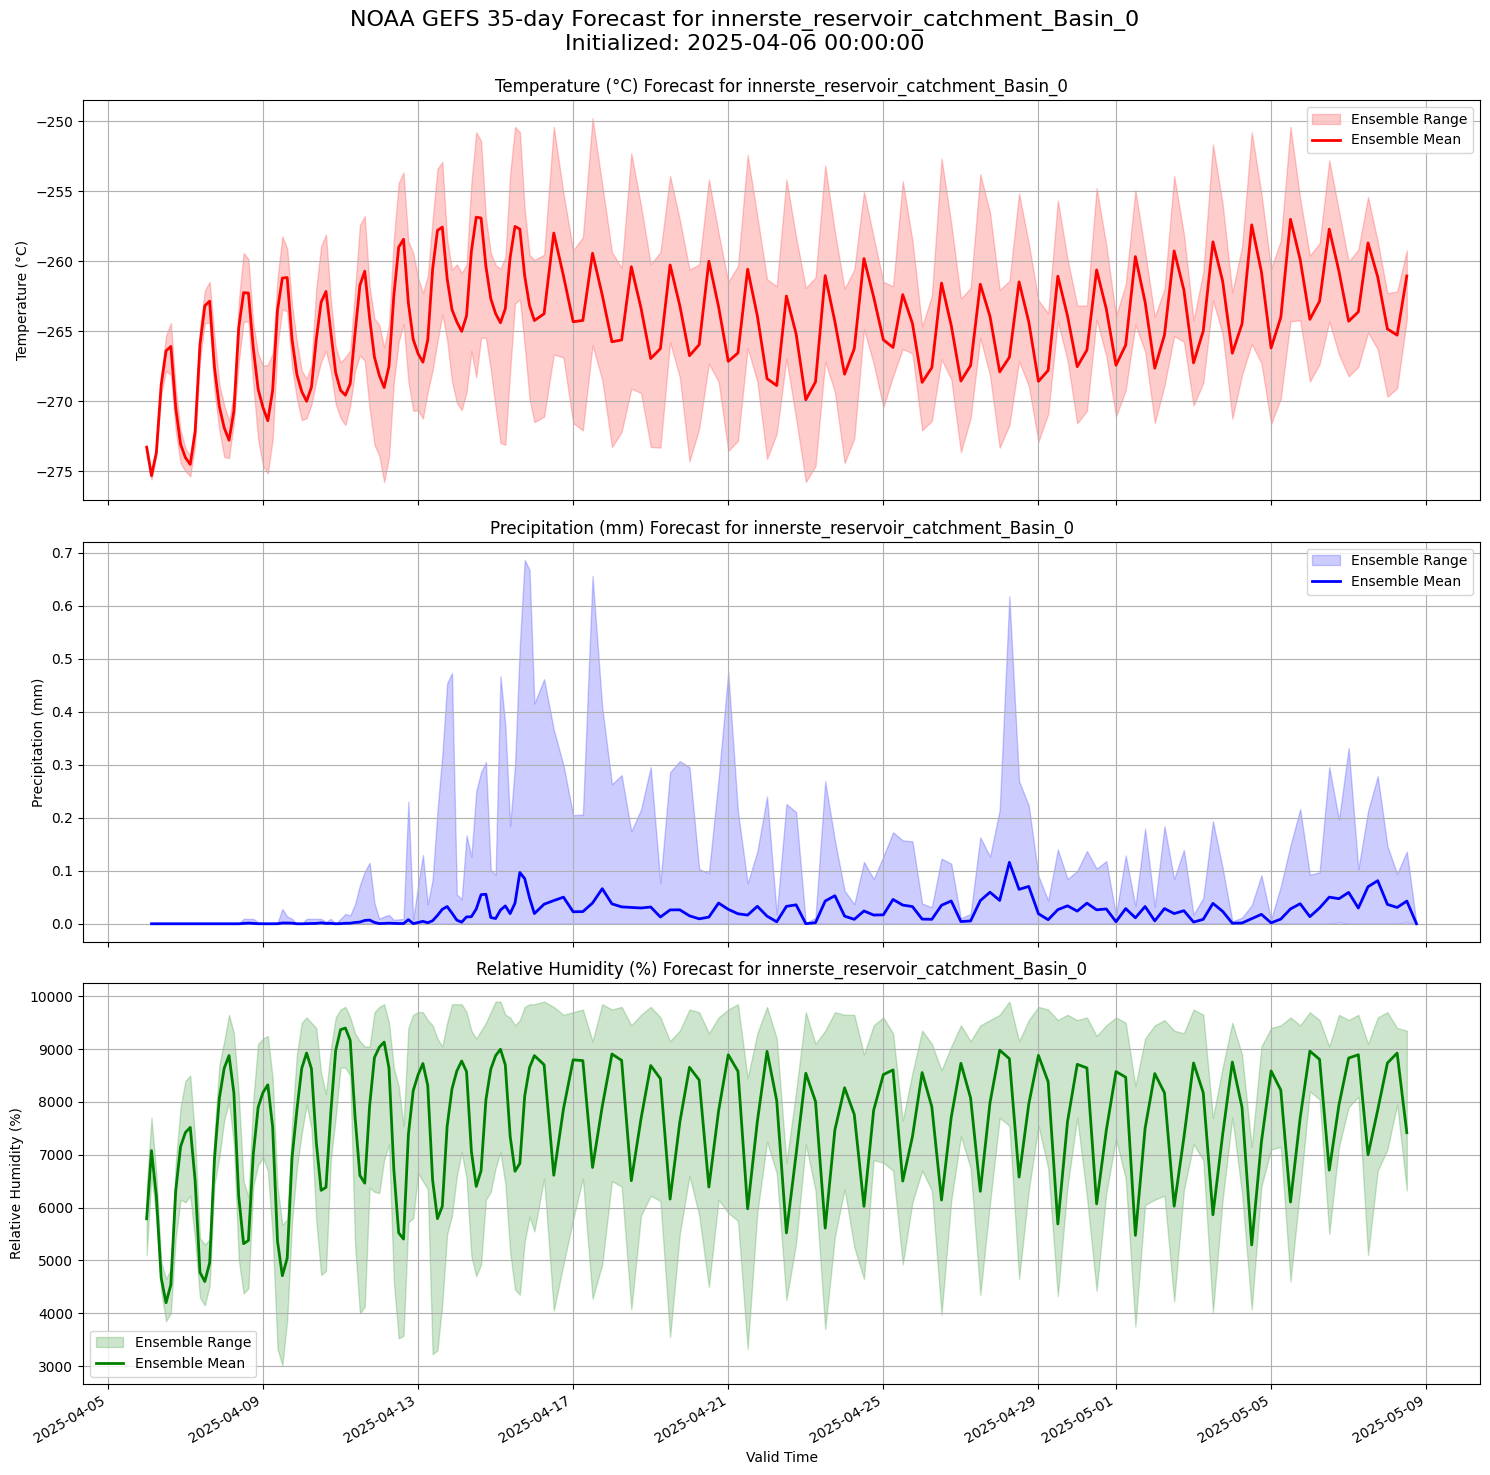

In [ ]:
# Plot example forecasts for one basin
if unified_ds is not None:
    # Select a single basin for plotting
    basin_name = basin_points['basin_name'].iloc[0]  # Take the first basin
    print(f"Creating forecast plots for basin: {basin_name}")
    
    # Select the most recent forecast initialization time
    latest_init = pd.to_datetime(unified_ds.time.values).max()
    print(f"Using forecast initialized at: {latest_init}")
    
    # Pre-compute the data we need before plotting to avoid multiple dask computations
    # Select basin and time first
    basin_forecast = unified_ds.sel(basin=basin_name, time=latest_init)
    
    # List of variables to plot
    plot_vars = [
        ('forecast_temperature_2m', 'Temperature (°C)', 'red', lambda x: x - 273.15),  # K to °C
        ('forecast_precipitation_surface', 'Precipitation (mm)', 'blue', lambda x: x * 1000),  # to mm
        ('forecast_relative_humidity_2m', 'Relative Humidity (%)', 'green', lambda x: x * 100)  # to %
    ]
    
    # Create valid_times for x-axis
    valid_times = latest_init + pd.to_timedelta(basin_forecast.lead_time.values, unit='h')
    
    # Compute all data at once to improve performance
    data_to_compute = {}
    for var_name, _, _, transform in plot_vars:
        data_to_compute[var_name] = transform(basin_forecast[var_name])
    
    print("Computing data (this may take a moment)...")
    computed_data = {k: v.compute() for k, v in data_to_compute.items()}
    print("Data computed, creating plots...")
    
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(3, 1, figsize=(15, 15), sharex=True)
    
    # Plot each variable
    for i, (var_name, ylabel, color, _) in enumerate(plot_vars):
        data = computed_data[var_name]
        
        # Plot ensemble spread as shaded region (faster than individual lines)
        ensemble_min = data.min(dim='ensemble_member')
        ensemble_max = data.max(dim='ensemble_member')
        ensemble_mean = data.mean(dim='ensemble_member')
        
        # Plot a light shaded area for min-max range
        axs[i].fill_between(valid_times, ensemble_min, ensemble_max, 
                          alpha=0.2, color=color, label='Ensemble Range')
        
        # Plot the ensemble mean with a thicker line
        axs[i].plot(valid_times, ensemble_mean, color=color, linewidth=2, label='Ensemble Mean')
        
        axs[i].set_title(f'{ylabel} Forecast for {basin_name}')
        axs[i].set_ylabel(ylabel)
        axs[i].legend()
        axs[i].grid(True)
    
    # Set x-axis label on the bottom subplot
    axs[2].set_xlabel('Valid Time')
    
    # Format x-axis dates
    fig.autofmt_xdate()
    
    # Add overall title
    plt.suptitle(f'NOAA GEFS 35-day Forecast for {basin_name}\nInitialized: {latest_init}', 
                 fontsize=16, y=0.98)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    plt.show()
else:
    print("Unified dataset is not available for plotting.")